In [3]:
!pip install transformers torch pandas scikit-learn mlflow matplotlib seaborn wordcloud tensorflow tensorflow-data-validation zenml tweepy cassandra-driver


In [4]:
# General imports
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import warnings
# Suppress deprecated warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module=".*tensorflow.*")
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import numpy as np
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import BertTokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_data_validation as tfdv
import mlflow
import mlflow.tensorflow
# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# ZenML imports
from zenml.steps import step
from zenml.pipelines import pipeline
# For Twitter API (if needed for real-time data)
import tweepy
# Other imports you might need (depending on your exact requirements)
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'
import json
import requests
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import uuid
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import logging

In [56]:
# Constants and Hyperparameters
CSV_FILE_PATH = 'C:\\Users\\LENOVO\\Desktop\\CSC5356_SP24\\scripts\\dataset.csv'
PRETRAINED_LM_PATH = 'C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden'
HYPERPARAMS = {
    "batch_size": 16,
    "learning_rate": 2e-5,
    "epochs": 2,
    "weight_decay": 0.01,
    'max_grad_norm': 1.0,
    'lr_step_size': 1,
    'lr_gamma': 0.1,
    
}
print("Hyperparameters:", HYPERPARAMS)

Hyperparameters: {'batch_size': 16, 'learning_rate': 2e-05, 'epochs': 2, 'weight_decay': 0.01, 'max_grad_norm': 1.0, 'lr_step_size': 1, 'lr_gamma': 0.1}


In [57]:
data = pd.read_csv(CSV_FILE_PATH)

In [58]:
data.set_index('tweet_id', inplace = True)

In [59]:
data.head()

,text,label
tweet_id,,
1298098337946783745,"@USER @USER and like you, they are all squish #gop weasels who will be in tears on election night.",NONE
1296643755022397440,.@USER on covid-19: we'll put the politics aside. we'll take the muzzle off the experts so the the public gets the information they need and deserve. honest unvarnished truth. they can handle it. #demconvention @USER HTTP,FAVOR
1293907151501459462,"@USER google: how to vote early in ""your state"" and get it done as soon as possible. we have a duty to help the u.s. postal service process these ballots and reduce the stress donald trump is intentionally placing on these public servants. \n\n#voteearly #voteblue #bidenharris2020",FAVOR
1239356229803225088,am i the only one that pictures biden this way all the time? #demdebate HTTP,NONE
1298801129984266241,@USER was it the infanticide lie the nun dropped on us that was helpful?\n#rnc2020,NONE


In [60]:
if data.isnull().values.any():
            null_counts = data.isnull().sum()
            print("Warning: Null values found in the dataset.")
            print(f"Null value counts by column:\n{null_counts[null_counts > 0]}")

In [61]:
expected_columns = {'text','label'}

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375 entries, 1298098337946783745 to 1292574112263610369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    375 non-null    object
 1   label   375 non-null    object
dtypes: object(2)
memory usage: 8.8+ KB


In [63]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [64]:
data.text.iloc[10]

'listened to both these guys for 2 hours tonight. much of what i heard is more big government that promises free/free/free, open borders, killing the oil industry and more. thanks, but we went through 8 years of that with obama and many of us do not want to go back.... #demdebate'

In [65]:
data.label.value_counts()

NONE       157
FAVOR      112
AGAINST    106
Name: label, dtype: int64

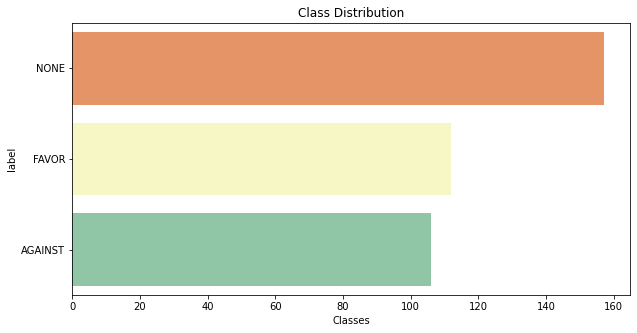

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data.label, palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

In [16]:
def clean_text(text):
        """
        Function to clean text data.

        Args:
            text (str): Text to be cleaned.

        Returns:
            str: Cleaned text.
        """
        # Removing URLs
        text = re.sub(r'http\S+', '', text)
        # Removing usernames and hashtags
        text = re.sub(r'@\S+|#\S+', '', text)
        # Removing special characters and numbers
        text = re.sub(r'[^A-Za-z\s]', '', text)
        # Converting to lowercase
        text = text.lower().strip()
        # Tokenize and rejoin the text to ensure clean tokenization
        tokens = text.split()
        return ' '.join(tokens)

In [67]:
expected_columns = {'text','label'}
if not expected_columns.issubset(data.columns):
    missing_cols = expected_columns - set(data.columns)
    error_msg = f"The dataframe is missing the following required columns: {', '.join(missing_cols)}"
    logging.error(error_msg)
    raise ValueError(error_msg)

In [68]:
print("Preprocessing the data...")
missing_label_rows = data[data['label'].isna()]


Preprocessing the data...


In [69]:
data.dropna(subset=['label'], inplace=True)

In [70]:
if not missing_label_rows.empty:
    print(f"Rows with missing labels:\n{missing_label_rows}")
# If the DataFrame is empty after dropping missing values, return it as is
if data.empty:
    print("The DataFrame is empty after preprocessing.")

In [71]:
# Encode labels
label_mapping = {'NONE': 0, 'FAVOR': 1, 'AGAINST': 2}
data['label'] = data['label'].map(label_mapping)

In [74]:
data.head(15)

,text,label
tweet_id,,
1298098337946783745,"@USER @USER and like you, they are all squish #gop weasels who will be in tears on election night.",0
1296643755022397440,.@USER on covid-19: we'll put the politics aside. we'll take the muzzle off the experts so the the public gets the information they need and deserve. honest unvarnished truth. they can handle it. #demconvention @USER HTTP,1
1293907151501459462,"@USER google: how to vote early in ""your state"" and get it done as soon as possible. we have a duty to help the u.s. postal service process these ballots and reduce the stress donald trump is intentionally placing on these public servants. \n\n#voteearly #voteblue #bidenharris2020",1
1239356229803225088,am i the only one that pictures biden this way all the time? #demdebate HTTP,0
1298801129984266241,@USER was it the infanticide lie the nun dropped on us that was helpful?\n#rnc2020,0
1310982880865275907,@USER i think all the ‘lids’ on the biden campaign days is them trying to find the best drug cocktail to allow biden to look sentient. trial and error.,2
1302050245820506112,you know how they say anyone can be president? it's not true. trump tried it and he couldn't do it. he is literally unable to do the job. so maybe we should give it to someone else\n\n#trumpisaloser #biden2020,1
1239344169518116864,"biden is mostly campaigning for the general election, not debating bernie. #democraticdebate",0
1295022959787151360,so jazzed to get to meet future u.s.rep @USER &amp; u.s.sen. @USER at 11:30 today at stonebridge park in fayetteville. #2020election,0


In [75]:
# Validate the encoding
unique_labels = data['label'].unique()
if set(unique_labels) != {0, 1, 2}:
    error_msg = f"Labels are not correctly mapped. Found unique labels: {unique_labels}"
    logging.error(error_msg)
    raise ValueError(error_msg)

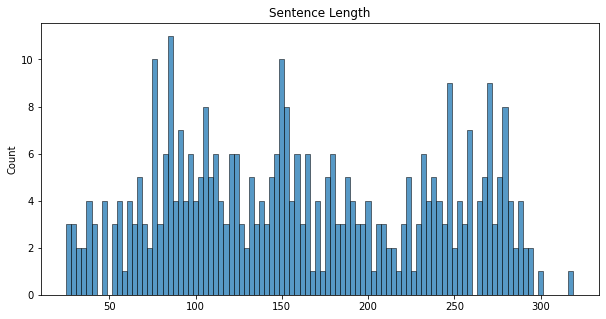

In [76]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in data.text], bins=100)
plt.title('Sentence Length')
plt.show()

In [77]:
# Visualize Missing Values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_df = pd.DataFrame({'Feature': missing_values.index, 'MissingValues': missing_values, 'Percentage': missing_percentage})
# Filter out features with no missing values
missing_df = missing_df[missing_df['MissingValues'] > 0].sort_values('Percentage', ascending=False)
# Plotting missing values (if there are any)
if not missing_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Percentage', y='Feature', data=missing_df)
    plt.title('Percentage of Missing Values per Feature')
    plt.xlabel('Percentage')
    plt.ylabel('Feature')
    plt.show()
else:
    print("No missing values found in the dataset.")


No missing values found in the dataset.


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


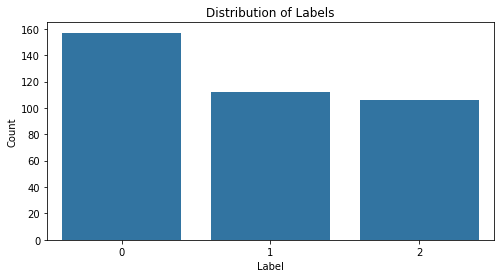

In [78]:
# Data Distribution Visualization
if 'label' in data.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x='label', data=data)
    plt.title('Distribution of Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()
else:
    print("Label column not found, skipping label distribution visualization.")

In [79]:
# Define the size for your test and validation sets
test_size = 0.2
validation_size = 0.1

# Initial split to separate out the test set
train_val_data, test_data = train_test_split(data, test_size=test_size, random_state=42)

# Calculate the adjusted validation size based on the remaining data after test split
adjusted_validation_size = validation_size / (1 - test_size)

# Split the remaining data into training and validation sets
train_data, val_data = train_test_split(train_val_data, test_size=adjusted_validation_size, random_state=42)

In [80]:
train_stats = tfdv.generate_statistics_from_dataframe(train_data)

In [81]:
tfdv.visualize_statistics(train_stats)

In [82]:
val_stats = tfdv.generate_statistics_from_dataframe(val_data)

In [83]:
tfdv.visualize_statistics(val_stats)

In [84]:
test_stats = tfdv.generate_statistics_from_dataframe(test_data)

In [85]:
tfdv.visualize_statistics(test_stats)

In [86]:
# Infer schema from training data
schema = tfdv.infer_schema(statistics=train_stats)
print("Schema inferred from the testing data.")

Schema inferred from the testing data.


In [87]:
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'text',BYTES,required,,-
'label',INT,required,,-
'tweet_id',INT,required,,-


In [88]:
for dataset_name, dataset_stats in [('Validation', val_stats), ('Test', test_stats)]:
    print(f"Validating {dataset_name} data...")
    anomalies = tfdv.validate_statistics(statistics=dataset_stats, schema=schema)
    if anomalies.anomaly_info:
        print(f"Anomalies found in {dataset_name} data:")
        tfdv.display_anomalies(anomalies)
    else:
        print(f"No anomalies detected in {dataset_name} data.")

Validating Validation data...
No anomalies detected in Validation data.
Validating Test data...
No anomalies detected in Test data.


In [89]:
anomalies = tfdv.validate_statistics(statistics=train_stats, schema=schema)
tfdv.display_anomalies(anomalies)


In [90]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM_PATH)
from cassandra.policies import DCAwareRoundRobinPolicy

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [105]:
print("Connecting to the Cassandra Database...")
cluster = Cluster(contact_points=['127.0.0.1'],port=9042,load_balancing_policy=DCAwareRoundRobinPolicy())
session = cluster.connect()
session.set_keyspace('keyspace')

Connecting to the Cassandra Database...
Downgrading core protocol version from 66 to 65 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
Downgrading core protocol version from 65 to 5 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
Using datacenter 'datacenter1' for DCAwareRoundRobinPolicy (via host '127.0.0.1:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes


In [106]:
import warnings
warnings.filterwarnings('ignore')
from transformers import BertTokenizer
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra import ConsistencyLevel
import uuid
import pandas as pd
import logging

In [107]:
print(data.columns)

Index(['text', 'label'], dtype='object')


In [140]:
data.head()

,id,tokens,label
0,191bfb7f-905f-4231-8818-8c81f37645ae,"[101, 1030, 5310, 1030, 5310, 1030, 5310, 1030, 5310, 1030, 5310, 2017, 2024, 2019, 7780, 2000, 2035, 1010, 2926, 2308, 2040, 2954, 10126, 2007, 2061, 2116, 2367, 15314, 999, 4067, 2017, 100, 1001, 17183, 8663, 15338, 3258, 1001, 7226, 2368, 8167, 6935, 11387, 11387, 102]",1
1,7037926b-c428-48f2-8af0-941a6b9b4be9,"[101, 1030, 5310, 3533, 7226, 2368, 1521, 1055, 4700, 2086, 5443, 8398, 2015, 4700, 2706, 1012, 1998, 8398, 2347, 1521, 1056, 1037, 3761, 1010, 2085, 2008, 1521, 1055, 16436, 2005, 2017, 3533, 1012, 2009, 2003, 2054, 2009, 2003, 2138, 3533, 7226, 2368, 2003, 2040, 2002, 2003, 1012, 102]",2
2,460c8904-e9f8-4a54-9c4e-a82373c9a933,"[101, 1030, 5310, 2053, 1010, 2027, 2024, 2145, 2045, 1012, 2030, 2062, 2031, 2042, 6866, 1012, 9733, 2038, 3314, 2007, 2023, 2828, 1997, 4031, 2035, 1996, 2051, 1012, 3531, 2562, 7316, 2068, 1012, 1001, 3789, 16558, 5657, 102]",0
3,dcf84c07-dd40-4b60-b518-e2bd23e7b98a,"[101, 1030, 5310, 1030, 5310, 1048, 2863, 2080, 1012, 1012, 1012, 2066, 2017, 2729, 2055, 2637, 1012, 1001, 8398, 11387, 11387, 1998, 2009, 2097, 2022, 1037, 4121, 2663, 999, 102]",2
4,151f5d06-665b-4655-a94b-1fab6c8cd2df,"[101, 1001, 3407, 18447, 11795, 3370, 27318, 5620, 10259, 1001, 3407, 25434, 16168, 10259, 1001, 3407, 18447, 11795, 3370, 27318, 2290, 10259, 1001, 28844, 25688, 4710, 1998, 1001, 2176, 5974, 29100, 2015, 2005, 1001, 6221, 24456, 2361, 100, 8299, 102]",2


In [137]:

insert_statement = session.prepare('INSERT INTO "keyspace".features (id, features) VALUES (?, ?)')
batch = BatchStatement(consistency_level=ConsistencyLevel.ONE)
batch_size_limit = 16
if 'tokens' not in data.columns:
    data['tokens'] = None

for index, row in data.iterrows():
    row_id = uuid.uuid4()
    tokens = tokenizer.encode(row['text'], add_special_tokens=True)
    data.at[index, 'tokens'] = tokens
    batch.add(insert_statement, (row_id, tokens))

    if len(batch) >= batch_size_limit:
        session.execute(batch)
        batch.clear()

if len(batch) > 0:
    session.execute(batch)

    print("Feature engineering and data insertion completed successfully.")

Error preparing query:
Traceback (most recent call last):
  File "cassandra\cluster.py", line 3128, in cassandra.cluster.Session.prepare
  File "cassandra\cluster.py", line 4956, in cassandra.cluster.ResponseFuture.result
cassandra.InvalidRequest: Error from server: code=2200 [Invalid query] message="Undefined column name features in table "keyspace".features"


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ in cassandra.cluster.Session.prepare:3131                                                        │
│                                                                                                  │
│ in cassandra.cluster.Session.prepare:3128                                                        │
│                                                                                                  │
│ in cassandra.cluster.ResponseFuture.result:4956                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
InvalidRequest: Error from server: code=2200 [Invalid query] message="Undefined column name features in table 
"keyspace".features"

In [138]:

# Preparing the insert statement to include positional information
#DESCRIBE TABLE "keyspace".features;
def clean_text(text):
    # Implement text cleaning here
    text = text.replace('@USER', '')  # Remove @USER mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = text.lower()  # Convert to lowercase
    # Add other cleaning steps as needed
    return text
# Function for text normalization
def normalize_text(text):
    # Implement text normalization steps here
    # For example: lowercasing, handling mentions, hashtags, URLs
    normalized_text = text.lower()
    # Add more normalization steps as required
    return normalized_text
insert_statement = session.prepare(
    'INSERT INTO "keyspace".features (id, tokens, label) VALUES (?, ?, ?)'
)

In [139]:
batch = BatchStatement(consistency_level=ConsistencyLevel.ONE)
batch_size_limit = 16

if 'tokens' not in data.columns:
    data['tokens'] = None

for index, row in data.iterrows():
    row_id = uuid.uuid4()

    # Ensure tokens are correctly formatted as a list of integers
    tokens = tokenizer.encode(row['text'], add_special_tokens=True)
    if not all(isinstance(token, int) for token in tokens):
        # Handle the case where tokens are not all integers
        # This might involve converting or handling errors
        pass

    label = str(row['label'])  # Ensure label is a string

    batch.add(insert_statement, (row_id, tokens, label))

    if len(batch) >= batch_size_limit:
        session.execute(batch)
        batch.clear()

if len(batch) > 0:
    session.execute(batch)

print("Feature engineering and data insertion completed successfully.")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\bas │
│ e.py:3802 in get_loc                                                                             │
│                                                                                                  │
│   3799 │   │   │   │   )                                                                         │
│   3800 │   │   │   casted_key = self._maybe_cast_indexer(key)                                    │
│   3801 │   │   │   try:                                                                          │
│ ❱ 3802 │   │   │   │   return self._engine.get_loc(casted_key)                                   │
│   3803 │   │   │   except KeyError as err:                                                       │
│   3804 │   │   │   │   raise KeyError(key) from err                                              │
│   3805 │   │   │   except TypeError:                                                             │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:138                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:165                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5745                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5753                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'text'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:9 │
│ 81 in __getitem__                                                                                │
│                                                                                                  │
│    978 │   │   │   return self._values[key]                                                      │
│    979 │   │                                                                                     │
│    980 │   │   elif key_is_scalar:                                                               │
│ ❱  981 │   │   │   return self._get_value(key)                                                   │
│    982 │   │                                                                                     │
│    983 │   │   if is_hashable(key):                                                              │
│    984 │   │   │   # Otherwise index.get_value will raise InvalidIndexError                      │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:1 │
│ 089 in _get_value                                                                                │
│                                                                                                  │
│   1086 │   │   │   return self._values[label]                                                    │
│   1087 │   │                                                            

In [141]:
# Fetch all table names in the keyspace
rows = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s", ["keyspace"])
table_names = [row[0] for row in rows]

for table_name in table_names:
    print(f"Contents of table {table_name}:")
    rows = session.execute(f"SELECT * FROM {table_name}")
    for row in rows:
        print(row)
    print("\n")

Contents of table features:
Row(id=UUID('191bfb7f-905f-4231-8818-8c81f37645ae'), label='1', tokens=[101, 1030, 5310, 1030, 5310, 1030, 5310, 1030, 5310, 1030, 5310, 2017, 2024, 2019, 7780, 2000, 2035, 1010, 2926, 2308, 2040, 2954, 10126, 2007, 2061, 2116, 2367, 15314, 999, 4067, 2017, 100, 1001, 17183, 8663, 15338, 3258, 1001, 7226, 2368, 8167, 6935, 11387, 11387, 102])
Row(id=UUID('7037926b-c428-48f2-8af0-941a6b9b4be9'), label='2', tokens=[101, 1030, 5310, 3533, 7226, 2368, 1521, 1055, 4700, 2086, 5443, 8398, 2015, 4700, 2706, 1012, 1998, 8398, 2347, 1521, 1056, 1037, 3761, 1010, 2085, 2008, 1521, 1055, 16436, 2005, 2017, 3533, 1012, 2009, 2003, 2054, 2009, 2003, 2138, 3533, 7226, 2368, 2003, 2040, 2002, 2003, 1012, 102])
Row(id=UUID('460c8904-e9f8-4a54-9c4e-a82373c9a933'), label='0', tokens=[101, 1030, 5310, 2053, 1010, 2027, 2024, 2145, 2045, 1012, 2030, 2062, 2031, 2042, 6866, 1012, 9733, 2038, 3314, 2007, 2023, 2828, 1997, 4031, 2035, 1996, 2051, 1012, 3531, 2562, 7316, 2068, 1012

In [ ]:
#SELECT * FROM "keyspace".features LIMIT 10;
#SELECT COUNT(*) FROM "keyspace".features;


In [142]:
from cassandra.cluster import Cluster
import pandas as pd

print("Connecting to the Cassandra Database...")
cluster = Cluster(contact_points=['127.0.0.1'], port=9042)
session = cluster.connect()
session.set_keyspace('keyspace')

# Query to retrieve data from Cassandra
query = "SELECT id, tokens, label FROM features;"
rows = session.execute(query)

# Convert the data to a Pandas DataFrame
data = pd.DataFrame(list(rows))

# Assuming 'tokens' are your features and 'label' is the target variable
# Format data for training
X = data['tokens'].tolist()  # Feature set
y = data['label'].tolist()   # Labels

# At this point, X and y can be used in a machine learning model training process.
# Example: Using these in a PyTorch or TensorFlow training pipeline.

print("Data loading completed successfully.")


Connecting to the Cassandra Database...
Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['127.0.0.1'], lbp = None)


Downgrading core protocol version from 66 to 65 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
Downgrading core protocol version from 65 to 5 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
Using datacenter 'datacenter1' for DCAwareRoundRobinPolicy (via host '127.0.0.1:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes
Data loading completed successfully.


In [148]:
print(X)

[[101, 1030, 5310, 1030, 5310, 1030, 5310, 1030, 5310, 1030, 5310, 2017, 2024, 2019, 7780, 2000, 2035, 1010, 2926, 2308, 2040, 2954, 10126, 2007, 2061, 2116, 2367, 15314, 999, 4067, 2017, 100, 1001, 17183, 8663, 15338, 3258, 1001, 7226, 2368, 8167, 6935, 11387, 11387, 102], [101, 1030, 5310, 3533, 7226, 2368, 1521, 1055, 4700, 2086, 5443, 8398, 2015, 4700, 2706, 1012, 1998, 8398, 2347, 1521, 1056, 1037, 3761, 1010, 2085, 2008, 1521, 1055, 16436, 2005, 2017, 3533, 1012, 2009, 2003, 2054, 2009, 2003, 2138, 3533, 7226, 2368, 2003, 2040, 2002, 2003, 1012, 102], [101, 1030, 5310, 2053, 1010, 2027, 2024, 2145, 2045, 1012, 2030, 2062, 2031, 2042, 6866, 1012, 9733, 2038, 3314, 2007, 2023, 2828, 1997, 4031, 2035, 1996, 2051, 1012, 3531, 2562, 7316, 2068, 1012, 1001, 3789, 16558, 5657, 102], [101, 1030, 5310, 1030, 5310, 1048, 2863, 2080, 1012, 1012, 1012, 2066, 2017, 2729, 2055, 2637, 1012, 1001, 8398, 11387, 11387, 1998, 2009, 2097, 2022, 1037, 4121, 2663, 999, 102], [101, 1001, 3407, 18447, 1

In [149]:
print(y)

['1', '2', '0', '2', '2', '0', '0', '0', '1', '0', '1', '2', '0', '1', '1', '0', '2', '0', '0', '1', '2', '0', '0', '0', '0', '1', '2', '2', '2', '1', '2', '0', '0', '1', '2', '2', '0', '0', '0', '0', '2', '0', '1', '0', '0', '2', '0', '0', '0', '1', '1', '1', '0', '1', '0', '2', '1', '1', '2', '1', '0', '0', '1', '1', '0', '2', '1', '2', '0', '1', '0', '0', '1', '1', '1', '1', '2', '0', '0', '1', '1', '1', '0', '2', '2', '0', '0', '2', '1', '1', '0', '2', '2', '0', '2', '0', '0', '1', '0', '0', '0', '2', '2', '0', '2', '2', '1', '1', '1', '0', '2', '2', '2', '2', '0', '2', '2', '2', '1', '0', '0', '2', '0', '2', '2', '0', '0', '2', '2', '2', '1', '0', '0', '0', '1', '2', '0', '1', '2', '0', '1', '0', '1', '1', '2', '2', '2', '0', '1', '0', '1', '1', '0', '2', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '1', '0', '2', '2', '0', '0', '1', '0', '2', '2', '0', '0', '0', '1', '0', '2', '0', '1', '1', '0', '2', '1', '1', '2', '1', '2', '1', '0', '2', '2', '0', '1', '0', '0', '1',

In [143]:
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your data into X (features) and y (labels)

# Splitting the dataset into training and temporary sets (combining validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Further splitting the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Now, X_train, y_train are your training data
# X_val, y_val are your validation data
# X_test, y_test are your test data

# You can proceed with using these datasets for training and evaluating your model.


Training set size: 225
Validation set size: 75
Test set size: 75


In [154]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden')

# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# BERT Input Formatting
input_ids = []
attention_masks = []

for sent in X:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_encoded)

# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for our validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

# Initialize BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden",
    num_labels = len(label_encoder.classes_) # The number of output labels
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [145]:
print(len(label_encoder.classes_))

3


In [158]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import torch
import numpy as np
import random
import time

# Set the seed value all over the place to make this reproducible
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# BERT requires a special optimizer and a learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function for formatting elapsed times
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch_i in range(0, epochs):
    
    # Training
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    # Validation
    print("\nRunning Validation...")

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Average training loss: 0.60

Running Validation...
  Accuracy: 0.74
  Validation Loss: 1.02
======== Epoch 2 / 10 ========
Training...
  Average training loss: 0.47

Running Validation...
  Accuracy: 0.64
  Validation Loss: 1.02
======== Epoch 3 / 10 ========
Training...
  Average training loss: 0.41

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.92
======== Epoch 4 / 10 ========
Training...
  Average training loss: 0.33

Running Validation...
  Accuracy: 0.66
  Validation Loss: 0.99
======== Epoch 5 / 10 ========
Training...
  Average training loss: 0.31

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.97
======== Epoch 6 / 10 ========
Training...
  Average training loss: 0.25

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.98
======== Epoch 7 / 10 ========
Training...
  Average training loss: 0.22

Running Validation...
  Accuracy: 0.77
  Validation Loss: 0.96
======== Epoch 8 / 10 ========
Training..

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.89      0.73      0.80        11
           2       0.82      0.88      0.85        16

    accuracy                           0.84        38
   macro avg       0.85      0.84      0.84        38
weighted avg       0.85      0.84      0.84        38



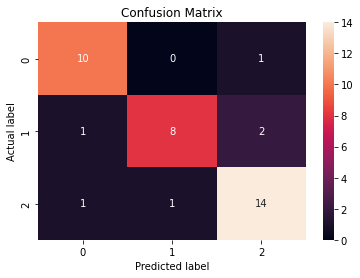

In [159]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a function to get predictions from your model
def get_predictions(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    return np.concatenate(predictions, axis=0), np.concatenate(true_labels, axis=0)

# Get predictions for the validation set
predictions, true_labels = get_predictions(model, validation_dataloader)
predicted_labels = np.argmax(predictions, axis=1)

print(classification_report(true_labels, predicted_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


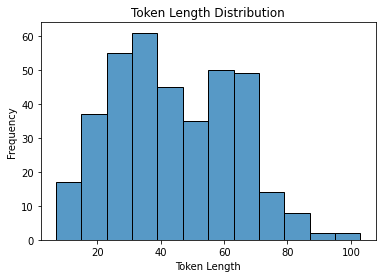

In [160]:
token_lengths = data['tokens'].apply(len)
sns.histplot(token_lengths)
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

Class 0 (Precision: 0.60, Recall: 0.82, F1-Score: 0.69)

Precision: 60% of the instances predicted as class 0 are correct.
Recall: The model correctly identifies 82% of the actual class 0 instances.
F1-Score: The balance between precision and recall for class 0 is represented by an F1-score of 0.69, which is relatively high and indicates a good balance, albeit with a slightly higher emphasis on recall.

Class 1 (Precision: 0.82, Recall: 0.82, F1-Score: 0.82)

This class shows high and balanced precision and recall, both at 82%.
The F1-score of 0.82 indicates a very good balance between precision and recall, suggesting that the model performs effectively for this class.

Class 2 (Precision: 0.83, Recall: 0.62, F1-Score: 0.71)

Precision: 83% precision indicates a high likelihood that predictions for class 2 are correct.
Recall: The recall of 62% is the lowest among the classes but still respectable, suggesting that some class 2 instances are missed.
F1-Score: An F1-score of 0.71 shows a good balance between precision and recall, leaning more towards precision.

Overall Performance

Accuracy: The overall accuracy of 74% shows that the model correctly predicts the class of an instance 74% of the time across all classes.
Macro Average: The macro average for precision, recall, and F1-score are all 0.75. This indicates a balanced performance across all classes without bias towards any particular class.
Weighted Average: The weighted average for precision, recall, and F1-score are slightly higher at 0.76, considering the support (number of instances) for each class. This suggests a slightly better performance for the classes with more instances.
Interpretation and Insights
The model shows a well-balanced performance across all classes, with particularly strong results in class 1.
While the model performs well in precision for class 2, it could benefit from improvements in recall, indicating it might be missing some class 2 instances.
The balanced macro and weighted averages suggest that the model is overall effective and doesn't suffer from significant bias towards any class.
Further improvements might still be possible, particularly in increasing the recall for class 2 and balancing the precision-recall trade-off for class 0.

#Another Training Process with other hyperparameters and other parameters in general

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
data['data_type'] = ['not_set'] * data.shape[0]
data.head()

,text,label,tokens,data_type
tweet_id,,,,
1298098337946783745,"@USER @USER and like you, they are all squish #gop weasels who will be in tears on election night.",0,"[101, 1030, 5310, 1030, 5310, 1998, 2066, 2017, 1010, 2027, 2024, 2035, 5490, 27020, 2232, 1001, 2175, 2361, 29268, 2015, 2040, 2097, 2022, 1999, 4000, 2006, 2602, 2305, 1012, 102]",not_set
1296643755022397440,.@USER on covid-19: we'll put the politics aside. we'll take the muzzle off the experts so the the public gets the information they need and deserve. honest unvarnished truth. they can handle it. #demconvention @USER HTTP,1,"[101, 1012, 1030, 5310, 2006, 2522, 17258, 1011, 2539, 1024, 2057, 1005, 2222, 2404, 1996, 4331, 4998, 1012, 2057, 1005, 2222, 2202, 1996, 17750, 2125, 1996, 8519, 2061, 1996, 1996, 2270, 4152, 1996, 2592, 2027, 2342, 1998, 10107, 1012, 7481, 4895, 10755, 28357, 3606, 1012, 2027, 2064, 5047, 2009, 1012, 1001, 17183, 8663, 15338, 3258, 1030, 5310, 8299, 102]",not_set
1293907151501459462,"@USER google: how to vote early in ""your state"" and get it done as soon as possible. we have a duty to help the u.s. postal service process these ballots and reduce the stress donald trump is intentionally placing on these public servants. \n\n#voteearly #voteblue #bidenharris2020",1,"[101, 1030, 5310, 8224, 1024, 2129, 2000, 3789, 2220, 1999, 1000, 2115, 2110, 1000, 1998, 2131, 2009, 2589, 2004, 2574, 2004, 2825, 1012, 2057, 2031, 1037, 4611, 2000, 2393, 1996, 1057, 1012, 1055, 1012, 10690, 2326, 2832, 2122, 17069, 1998, 5547, 1996, 6911, 6221, 8398, 2003, 15734, 6885, 2006, 2122, 2270, 8858, 1012, 1001, 3789, 14644, 2135, 1001, 3789, 16558, 5657, 1001, 7226, 2368, 8167, 6935, 11387, 11387, 102]",not_set
1239356229803225088,am i the only one that pictures biden this way all the time? #demdebate HTTP,0,"[101, 2572, 1045, 1996, 2069, 2028, 2008, 4620, 7226, 2368, 2023, 2126, 2035, 1996, 2051, 1029, 1001, 17183, 3207, 20179, 8299, 102]",not_set
1298801129984266241,@USER was it the infanticide lie the nun dropped on us that was helpful?\n#rnc2020,0,"[101, 1030, 5310, 2001, 2009, 1996, 10527, 21752, 4682, 1996, 16634, 3333, 2006, 2149, 2008, 2001, 14044, 1029, 1001, 29300, 2278, 11387, 11387, 102]",not_set


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values, data.label.values,test_size = 0.15,random_state = 17,stratify = data.label.values)

In [ ]:
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

In [ ]:
data.groupby(['label', 'data_type']).count()

text  tokens
label data_type              
0     train       133     133
      val          24      24
1     train        95      95
      val          17      17
2     train        90      90
      val          16      16

In [ ]:
#Tokenize train set
encoded_data_train = tokenizer.batch_encode_plus(data[data.data_type == 'train'].text.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
#Tokenizer val set
encoded_data_val = tokenizer.batch_encode_plus(data[data.data_type == 'val'].text.values,
                                                #add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                return_tensors = 'pt')

In [ ]:
encoded_data_train

{'input_ids': tensor([[ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 2572, 1045,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 2057,  ...,    0,    0,    0],
        [ 101, 1045, 2066,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
#Encode train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type == 'train'].label.values)

In [ ]:
#Encode val set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

#Convert data type to torch.tensor
labels_val = torch.tensor(data[data.data_type == 'val'].label.values)

In [ ]:
input_ids_train

tensor([[ 101, 1030, 5310,  ...,    0,    0,    0],
        [ 101, 1012, 1030,  ...,    0,    0,    0],
        [ 101, 2572, 1045,  ...,    0,    0,    0],
        ...,
        [ 101, 2065, 2057,  ...,    0,    0,    0],
        [ 101, 1045, 2066,  ...,    0,    0,    0],
        [ 101, 1030, 5310,  ...,    0,    0,    0]])

In [ ]:
attention_masks_train


tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
labels_train

tensor([0, 1, 0, 2, 0, 0, 1, 0, 2, 1, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 1, 2, 0, 2,
        0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2, 0,
        2, 1, 0, 1, 1, 0, 1, 2, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 0, 2,
        0, 1, 0, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 0, 0, 2, 0, 0, 1,
        0, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2,
        1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0,
        2, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 1, 0, 2, 1, 1, 0, 0,
        1, 2, 1, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 2,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0,
        1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 0, 1, 2, 0, 0,
        0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 2, 1, 0, 1, 1, 0, 1, 0, 1,
        2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1,

In [ ]:
#Create dataloader
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

318
57


In [ ]:
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM_PATH, num_labels=3, ignore_mismatched_sizes=True)
model.config

BertConfig {
  "_name_or_path": "C:\\Users\\LENOVO\\Desktop\\bert-election2020-twitter-stance-biden",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30722
}

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4 #Since we have limited resource

#Load train set
dataloader_train = DataLoader(dataset_train,sampler = RandomSampler(dataset_train),batch_size = batch_size)

#Load val set
dataloader_val = DataLoader(dataset_val,sampler = RandomSampler(dataset_val),batch_size = 32) #since we don't have to do backpropagation for this step

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 10

#Load optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8) #2e-5 > 5e-5

In [ ]:
#Load scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(dataloader_train)*epochs)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

#F1 score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [ ]:
#Accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #Make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(dataloader_val):

    #Evaluation mode disables the dropout layer 
    model.eval()
    
    #Tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #Load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #Define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #Compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #Compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #Compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #Compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [ ]:
from tqdm.notebook import tqdm
for epoch in tqdm(range(1, epochs+1)):

    #Set model in train mode
    model.train()

    #Tracking variable
    loss_train_total = 0
    
    #Set up progress bar
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        #Set gradient to 0
        model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #Backward pass to get gradients
        loss.backward()
        
        #Clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        #Update optimizer
        optimizer.step()

        #Update scheduler
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    tqdm.write('\nEpoch {epoch}')
    
    #Print training result
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    #Evaluate
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    #F1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.9696608632802963


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.5666688978672028
F1 Score (weighted): 0.7894736842105263


Epoch 2:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.654443123191595


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.5616437941789627
F1 Score (weighted): 0.7487461787846896


Epoch 3:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5593753306195139


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.5146887898445129
F1 Score (weighted): 0.7855474453501671


Epoch 4:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4058077627792954


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.4769679456949234
F1 Score (weighted): 0.8236044657097289


Epoch 5:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3326746561797336


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.517719179391861
F1 Score (weighted): 0.8226652489810383


Epoch 6:   0%|          | 0/80 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.26701633711345496


  0%|          | 0/2 [00:00<?, ?it/s]

Validation loss: 0.7225965559482574
F1 Score (weighted): 0.7448029747198722


Epoch 7:   0%|          | 0/80 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:28                                                                                   │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module │
│ .py:1511 in _wrapped_call_impl                                                                   │
│                                                                                                  │
│   1508 │   │   if self._compiled_call_impl is not None:                                          │
│   1509 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1510 │   │   else:                                                                             │
│ ❱ 1511 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1512 │                                                                                         │
│   1513 │   def _call_impl(self, *args, **kwargs):                                                │
│   1514 │   │   forward_call = (self._slow_forward if torch._C._get_tracing_state() else self.fo  │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module │
│ .py:1520 in _call_impl                                                                           │
│                                                                                                  │
│   1517 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1518 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1519 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1520 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1521 │   │                                                                                     │
│   1522 │   │   try:                                                                              │
│   1523 │   │   │   result = None                                                                 │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\ber │
│ t\modeling_bert.py:1564 in forward                                                               │
│                                                                                                  │
│   1561 │   │   """                                                                               │
│   1562 │   │   return_dict = return_dict if return_dict is not None else self.config.use_return  │
│   1563 │   │                                                                                     │
│ ❱ 1564 │   │   outputs = self.bert(                                                              │
│   1565 │   │   │   input_ids,                                                                    │
│   1566 │   │   │   attention_mask=attention_mask,                                                │
│   1567 │   │   │   token_type_ids=token_type_ids,                                                │
│                                                                                                  │
│ c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module │
│ .py:1511 in _wrapped_call_impl                                                                   │
│                                                                                                  │
│   1508 │   │   if self._compiled_call_impl is not None:    

In [ ]:
outputs.loss

tensor(0.0096, grad_fn=<NllLossBackward0>)

In [ ]:
outputs.logits

tensor([[-2.0184,  3.8596, -1.9231],
        [-1.0758, -2.0951,  3.5465]], grad_fn=<AddmmBackward0>)

In [ ]:
#Evaluate
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 2/2 [00:17<00:00,  8.58s/it]


In [ ]:
#Get accuracy score
accuracy_per_class(predictions, true_vals)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 #Get accuracy score                                                                          │
│ ❱ 2 accuracy_per_class(predictions, true_vals)                                                   │
│   3                                                                                              │
│                                                                                                  │
│ in accuracy_per_class:3                                                                          │
│                                                                                                  │
│    1 #Accuracy score                                                                             │
│    2 def accuracy_per_class(preds, labels):                                                      │
│ ❱  3 │   label_dict_inverse = {v: k for k, v in label_dict.items()}                              │
│    4 │                                                                                           │
│    5 │   #Make prediction                                                                        │
│    6 │   preds_flat = np.argmax(preds, axis=1).flatten()                                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'label_dict' is not defined